In [1]:
from __future__ import print_function
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

## Reach Trainer

In [4]:
from pkg.detector.aruco.marker_config import *
from pkg.detector.aruco.stereo import ArucoStereo
from pkg.detector.camera.realsense import RealSense
from pkg.detector.camera.kinect import Kinect
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.planning.filtering.reach_filter import ReachTrainer
from pkg.controller.combined_robot import *
from pkg.utils.plot_utils import *

s_builder = SceneBuilder(None)
rtrain = ReachTrainer(scene_builder=s_builder)

## Feature Function Candidates

In [5]:
def fn_rpy(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    R = np.matmul(hori2mat(theta=0, azimuth_loc=azimuth_loc, zenith=zenith), Rot_axis(3, rot_z))
    r,p,y = Rot2rpy(R)
    return (radius, theta, height, r,p,y, radius**2, ee_dist, ee_dist**2)

def fn_quat(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    R = np.matmul(hori2mat(theta=0, azimuth_loc=azimuth_loc, zenith=zenith), Rot_axis(3, rot_z))
    x,y,z,w = Rotation.from_dcm(R).as_quat()
    return (radius, theta, height, x,y,z,w, radius**2, ee_dist, ee_dist**2)

def fn_rmat(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    R = np.matmul(hori2mat(theta=0, azimuth_loc=azimuth_loc, zenith=zenith), Rot_axis(3, rot_z))
    r11, r12, r13, r21, r22, r23, r31, r32, r33 = R.flatten()
    return (radius, theta, height, r11, r12, r13, r21, r22, r23, r31, r32, r33, radius**2, ee_dist, ee_dist**2)

def fn_zxvec(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    R = np.matmul(hori2mat(theta=0, azimuth_loc=azimuth_loc, zenith=zenith), Rot_axis(3, rot_z))
    z1, z2, z3 = R[:,2]
    x1, x2, x3 = R[:,0]
    return (radius, theta, height, z1, z2, z3, x1, x2, x3, radius**2, ee_dist, ee_dist**2)

def fn_pure(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    return (radius, theta, height, azimuth_loc, zenith, ee_dist, rot_z)

def fn_re_sq(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    return (radius, theta, height, azimuth_loc, zenith, radius**2, ee_dist, ee_dist**2, rot_z)

def fn_re_sq_norot(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    return (radius, theta, height, azimuth_loc, zenith, radius**2, ee_dist, ee_dist**2)

def fn_re_sq_xvec(radius,theta, height, azimuth_loc, zenith, ee_dist, rot_z):
    R = np.matmul(hori2mat(theta=0, azimuth_loc=azimuth_loc, zenith=zenith), Rot_axis(3, rot_z))
    x1, x2, x3 = R[:,0]
    return (radius, theta, height, azimuth_loc, zenith, radius**2, ee_dist, ee_dist**2, x1, x2, x3)

fn_list = [fn_rpy, fn_quat, fn_rmat, fn_zxvec, fn_pure, fn_re_sq, fn_re_sq_norot, fn_re_sq_xvec]


In [48]:
from pkg.planning.filtering.reach_filter import T2features, features2T

In [96]:
# fn_rpy test
for _ in range(100):
    Tbe = SE3(Rot_zyx(*np.random.uniform(-np.pi, np.pi, 3)), np.random.uniform(-1,1,3))
    ft = T2features(Tbe, 0.3)
    radius, theta, height, r,p,y, _, _, _ = fn_rpy(*ft)

    pos = cyl2cart(radius, theta, height)
    R = np.matmul(Rot_axis(3, theta), Rot_rpy((r,p,y)))
    Tn = SE3(R, pos)
    
    assert np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4)) < 1e-5, "feature not perfect"
np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4))

7.613049199941332e-08

In [40]:
# fn_quat test
for _ in range(100):
    Tbe = SE3(Rot_zyx(*np.random.uniform(-np.pi, np.pi, 3)), np.random.uniform(-1,1,3))
    ft = T2features(Tbe, 0.3)
    radius, theta, height, x,y,z,w, _, _, _ = fn_quat(*ft)

    pos = cyl2cart(radius, theta, height)
    R = np.matmul(Rot_axis(3, theta), Rotation.from_quat([x,y,z,w]).as_dcm())
    Tn = SE3(R, pos)
    
    assert np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4)) < 1e-5, "feature not perfect"
np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4))

7.048597766801884e-08

In [45]:
# fn_rmat test
for _ in range(100):
    Tbe = SE3(Rot_zyx(*np.random.uniform(-np.pi, np.pi, 3)), np.random.uniform(-1,1,3))
    ft = T2features(Tbe, 0.3)
    radius, theta, height, r11, r12, r13, r21, r22, r23, r31, r32, r33, _, _, _ = fn_rmat(*ft)

    pos = cyl2cart(radius, theta, height)
    R = np.matmul(Rot_axis(3, theta), np.reshape([r11, r12, r13, r21, r22, r23, r31, r32, r33],(3,3)))
    Tn = SE3(R, pos)
    
    assert np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4)) < 1e-5, "feature not perfect"
np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4))

2.2460229553322733e-07

In [49]:
# fn_pure test
for _ in range(100):
    Tbe = SE3(Rot_zyx(*np.random.uniform(-np.pi, np.pi, 3)), np.random.uniform(-1,1,3))
    ft = T2features(Tbe, 0.3)
    radius, theta, height, azimuth_loc, zenith, ee_dist, rot_z = fn_pure(*ft)

    Tn = features2T(radius, theta, height, azimuth_loc, zenith, ee_dist, rot_z)
    
    assert np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4)) < 1e-5, "feature not perfect"
np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4))

6.444047535513929e-08

In [51]:
# fn_re_sq test
for _ in range(100):
    Tbe = SE3(Rot_zyx(*np.random.uniform(-np.pi, np.pi, 3)), np.random.uniform(-1,1,3))
    ft = T2features(Tbe, 0.3)
    radius, theta, height, azimuth_loc, zenith, radius_2, ee_dist, ee_dist_2, rot_z = fn_re_sq(*ft)

    Tn = features2T(radius, theta, height, azimuth_loc, zenith, ee_dist, rot_z)
    
    assert np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4)) < 1e-5, "feature not perfect"
np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4))

8.549028538815462e-08

In [99]:
# fn_re_sq_norot test
for _ in range(100):
    Tbe = SE3(Rot_zyx(*np.random.uniform(-np.pi, np.pi, 3)), np.random.uniform(-1,1,3))
    ft = T2features(Tbe, 0.3)
    radius, theta, height, azimuth_loc, zenith, radius_2, ee_dist, ee_dist_2 = fn_re_sq_norot(*ft)

    Tn = features2T(radius, theta, height, azimuth_loc, zenith, ee_dist, 0)
    
    assert np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4)) < 1e-5, "feature not perfect"
np.linalg.norm(np.matmul(SE3_inv(Tbe), Tn) - np.identity(4))

AssertionError: feature not perfect

## Load previous result or initialize dict

In [68]:
ROBOT_TYPE = RobotType.panda
SAVE_DIR = os.path.join(os.environ["RNB_PLANNING_DIR"], "data", "reach_svm_ft_analysis")

In [69]:
try: 
    resdat = load_pickle(os.path.join(SAVE_DIR, "{}.pkl".format(ROBOT_TYPE.name)))
    test_panda_set_dict = resdat["test_panda_set_dict"]
    fn_names = resdat["fn_names"]
    C_svm_list = resdat["C_svm_list"]
    print("=== DATA LOADED ===")
    print("funcions: {}".format(fn_names))
    print("C_svm:    {}".format(C_svm_list))
except:
    test_panda_set_dict = {}

=== DATA LOADED ===
funcions: ['fn_rpy', 'fn_quat', 'fn_rmat', 'fn_zxvec', 'fn_pure', 'fn_re_sq', 'fn_re_sq_norot', 'fn_re_sq_xvec']
C_svm:    [500, 700, 1000, 2000, 4000, 6000, 8000]


In [70]:
samplevec_list_test, success_list_test = rtrain.load_data(ROBOT_TYPE, "test")
for fn in fn_list:
    fn(*samplevec_list_test[0])
    print("function ok: {}".format(fn.__name__))
print("function all sane")

C_svm_list = [500, 700, 1000, 2000, 4000, 6000, 8000]

function ok: fn_rpy
function ok: fn_quat
function ok: fn_rmat
function ok: fn_zxvec
function ok: fn_pure
function ok: fn_re_sq
function ok: fn_re_sq_norot
function ok: fn_re_sq_xvec
function all sane


In [71]:
for fn in fn_list:
    if fn.__name__ in test_panda_set_dict:
        test_panda_set = test_panda_set_dict[fn.__name__]
    else:
        test_panda_set = {}
    for C_svm in C_svm_list:
        if str(C_svm) in test_panda_set:
            print("ALREADY LOADED: {} - {}".format(fn.__name__, C_svm))
            continue
        print("LEARNING: {} - {}".format(fn.__name__, C_svm))
        test_panda = rtrain.load_and_learn(ROBOT_TYPE, C_svm=C_svm, feature_fn=fn)
        test_panda_set[str(C_svm)] = test_panda
    test_panda_set_dict[fn.__name__] = test_panda_set

ALREADY LOADED: fn_rpy - 500
ALREADY LOADED: fn_rpy - 700
ALREADY LOADED: fn_rpy - 1000
ALREADY LOADED: fn_rpy - 2000
ALREADY LOADED: fn_rpy - 4000
ALREADY LOADED: fn_rpy - 6000
ALREADY LOADED: fn_rpy - 8000
ALREADY LOADED: fn_quat - 500
ALREADY LOADED: fn_quat - 700
ALREADY LOADED: fn_quat - 1000
ALREADY LOADED: fn_quat - 2000
ALREADY LOADED: fn_quat - 4000
ALREADY LOADED: fn_quat - 6000
ALREADY LOADED: fn_quat - 8000
ALREADY LOADED: fn_rmat - 500
ALREADY LOADED: fn_rmat - 700
ALREADY LOADED: fn_rmat - 1000
ALREADY LOADED: fn_rmat - 2000
ALREADY LOADED: fn_rmat - 4000
ALREADY LOADED: fn_rmat - 6000
ALREADY LOADED: fn_rmat - 8000
ALREADY LOADED: fn_zxvec - 500
ALREADY LOADED: fn_zxvec - 700
ALREADY LOADED: fn_zxvec - 1000
ALREADY LOADED: fn_zxvec - 2000
ALREADY LOADED: fn_zxvec - 4000
ALREADY LOADED: fn_zxvec - 6000
ALREADY LOADED: fn_zxvec - 8000
ALREADY LOADED: fn_pure - 500
ALREADY LOADED: fn_pure - 700
ALREADY LOADED: fn_pure - 1000
ALREADY LOADED: fn_pure - 2000
ALREADY LOADED: fn

In [73]:
fn_names = map(lambda x:x.__name__, fn_list)

In [80]:
name_dict = {"fn_rpy": "rpy", "fn_quat": "quat", "fn_rmat": "mat", "fn_zxvec": "zx_vec", 
             "fn_pure": "no_square", "fn_re_sq": "roll", "fn_re_sq_norot": "proposed", "fn_re_sq_xvec":None}

In [81]:
plot_names = []
plot_dict = {}
for fn_name in fn_names:
    plot_name = name_dict[fn_name]
    if plot_name is not None:
        plot_names.append(plot_name)
        plot_dict[plot_name] = test_panda_set_dict[fn_name]
        
plot_names = ["no_square", "rpy", "quat", "mat", "zx_vec", "roll", "proposed"]

fn:    no_square       rpy      quat       mat    zx_vec      roll  proposed
vals:       93.6     93.06     93.98     93.44     94.02      93.9     94.76
max: 94.76 - ['proposed']


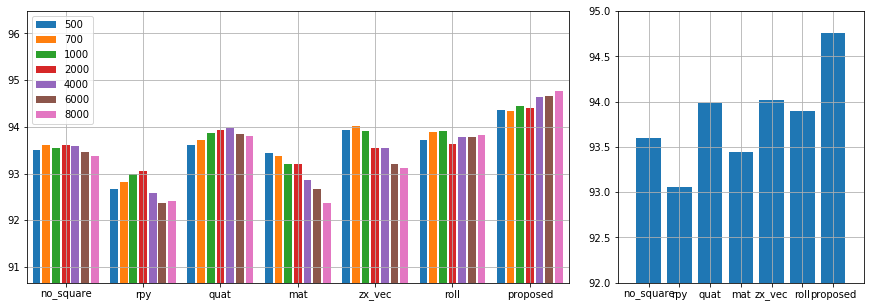

In [83]:

plot_maxvals = [max(plot_dict[plot_name].values()) for plot_name in plot_names]
plt.figure(figsize=(15,5))
plt.subplot(1,3,(1,2))
grouped_bar(plot_dict, groups=plot_names, options=map(str,C_svm_list))
plt.subplot(1,3,3)
plt.bar(plot_names, plot_maxvals)
plt.axis([-1, len(plot_names), 92, 95])
plt.grid()
maxval = np.max(plot_maxvals)
idc_max = np.where(np.array(plot_maxvals)==maxval)[0]
print("fn:   "+"".join(["{:>10}".format(fname) for fname in plot_names]))
print("vals: "+"".join(["{:10}".format(val) for val in plot_maxvals]))
print("max: {} - {}".format(maxval, [plot_names[idx] for idx in idc_max]))

In [93]:
plt.rcParams['font.size'] = 18
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['lines.linewidth'] = 2


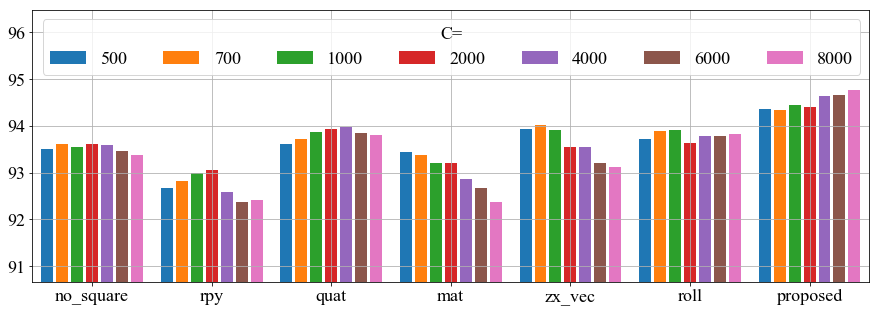

In [95]:
plot_maxvals = [max(plot_dict[plot_name].values()) for plot_name in plot_names]
plt.figure(figsize=(15,5))
grouped_bar(plot_dict, groups=plot_names, options=map(str,C_svm_list))
plt.legend(map(str,C_svm_list), title="C=", ncol=len(C_svm_list))

## Save result

In [15]:
try_mkdir(SAVE_DIR)
save_pickle(os.path.join(SAVE_DIR, "{}.pkl".format(rtrain.robot_type.name)),
            {"test_panda_set_dict":test_panda_set_dict, "fn_names":fn_names, "C_svm_list":C_svm_list})

## Validate train result

In [41]:
fn_best = fn_zxvec
fine_Clist = []
fine_results = []

In [42]:
for C_svm in [600, 700, 750, 800, 900]:
    test_panda = rtrain.load_and_learn(RobotType.panda, C_svm=C_svm, feature_fn=fn_best)
    fine_Clist.append(C_svm)
    fine_results.append(test_panda)

connection command:
panda0: False
trainset: 	1538.0 ms/1 = 1538.0 ms (1538.0/1538.0)
testset: 	382.1 ms/1 = 382.1 ms (382.067/382.067)

trainning accuracy = 96.77 %
test accuracy = 93.98 %
trainning success accuracy = 98.35 %
trainning failure accuracy = 94.39 %
test success accuracy = 95.46 %
test failure accuracy = 91.6 %


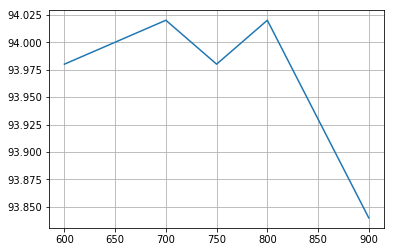

In [47]:
plt.plot(fine_Clist, fine_results)
plt.grid()